# CT Images Denoising - Synthetic Images

Description of the jupyter notebook and maybe brief overview of the all project.

**Authors:** [Raphaël Achddou](https://people.epfl.ch/raphael.achddou) ([contact](mailto:raphael.achddou@epfl.ch)), [Paulo Ribeiro](https://people.epfl.ch/paulo.ribeirodecarvalho) ([contact](mailto:paulo.ribeirodecarvalho@epfl.ch))

## Import
Let's first import all libraries needed for the production of synthetic images using dead leaves.

In [1]:
import matplotlib.pyplot as plt

from helpers import *
from skimage.morphology import disk, ellipse, square
from group_imgs_class import GroupReal, GroupSynth, RealImageCT, SynthImageCT
from dead_leaves_paulo import *

%load_ext autoreload
%autoreload 2

## Load Data

To create meaningful synthetic images, we made them statistically equivalent to real images. Then, samples of real CT images are needed.

In [2]:
# ~1min45s to load all 42'487 images
data_path = 'data'
data = GroupReal(load_data(data_path))

  0%|          | 0/42487 [00:00<?, ?it/s]

data/test/1mm B30/QD_1mm/L123/L123_QD_1_1.CT.0003.0256.2016.01.25.16.56.37.541912.412807243.IMA
test
1mm B30
quarter
L123


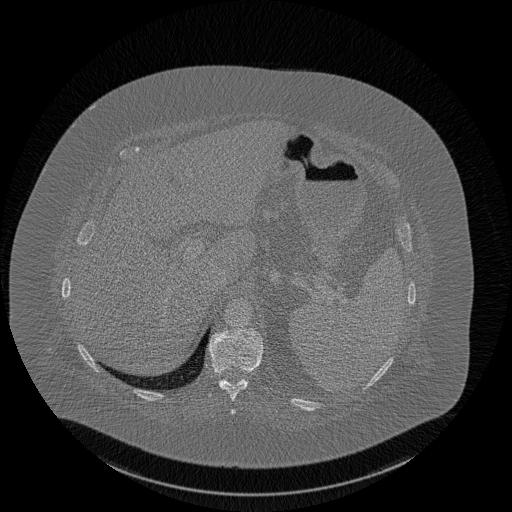

In [3]:
# TODO: (REMOVE) play with idx to check if the loading works properly
idx = 40000
print(data.imgs[idx].path)
print(data.imgs[idx].cat)
print(data.imgs[idx].type)
print(data.imgs[idx].dose)
print(data.imgs[idx].patient)
data.imgs[idx].pil

We can now have a look at each patient and each projection of the training images, but for computation purpose, let's focus on one specific batch.

In [4]:
# full dose image of patient L506 for one specific conditions
l506_fd = data.filter(cat=['train'],
                      img_type=['3mm B30'],
                      dose=['full'],
                      patient=['L506'])

# quarter dose image of patient L506 for one specific conditions
l506_qd = data.filter(cat=['train'],
                      img_type=['3mm B30'],
                      dose=['quarter'],
                      patient=['L506'])

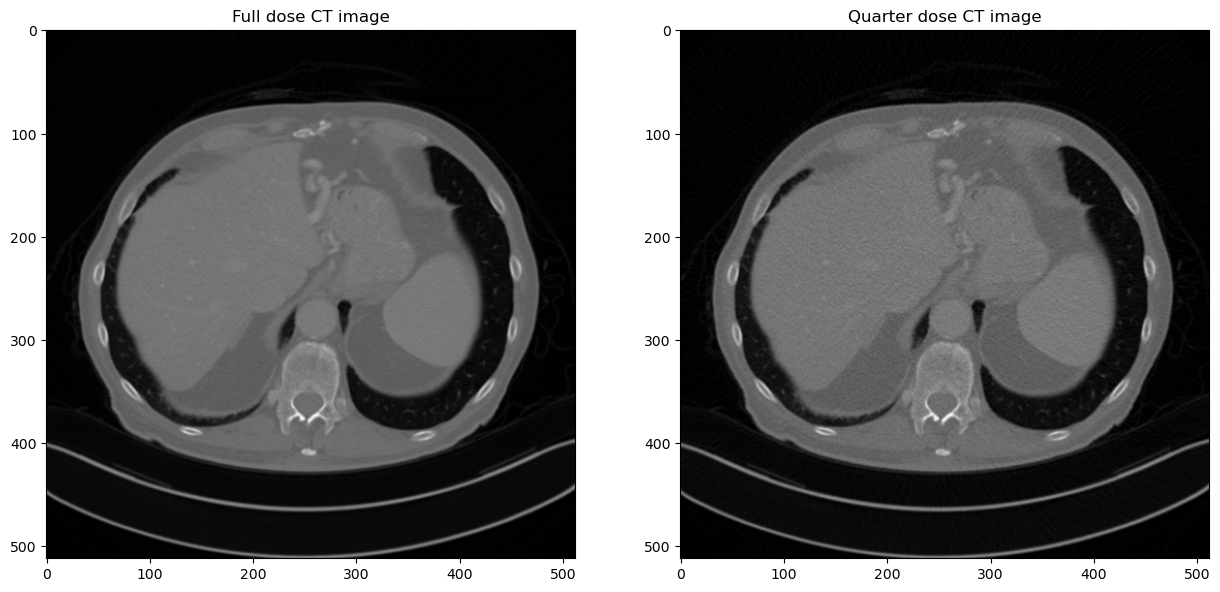

In [5]:
idx = 20  # select one of the 250 projection of patient L506

# Display the CT images to have a quick overview
fig, axs = plt.subplots(1, 2, figsize=(15, 15))

axs[0].imshow(l506_fd.imgs[idx].pil, cmap='grey')
axs[0].set_title('Full dose CT image')
axs[1].imshow(l506_qd.imgs[idx].pil, cmap='grey')
axs[1].set_title('Quarter dose CT image')

plt.show()

## Statistical Analysis

As mention above, a statistical analysis from the real CT images need to be done to replicate the statistics in our synthetic images. We will focus on these following stat metrics :

1) color distribution
2) morphological analysis
3) ...

### Color Distribution

Let's start by analyzing the color distribution of our real CT images. It is doing in a straightforward and easy manner by computing the histogram of the pixel intensities across all CT images from all patient.

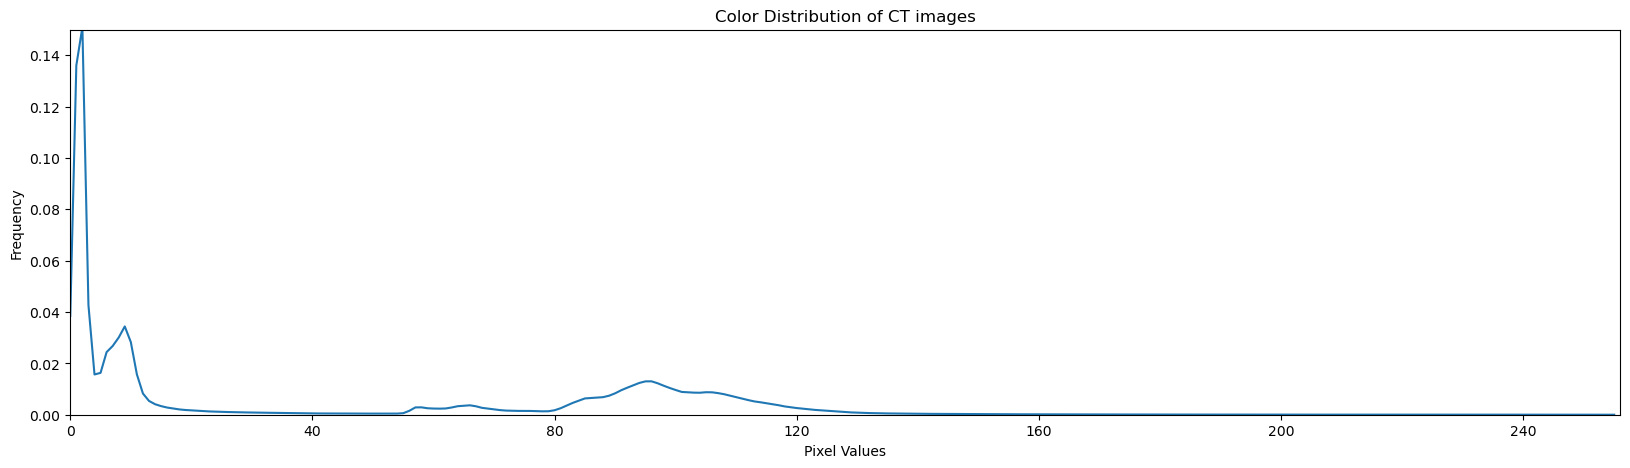

In [6]:
# Color distribution of full CT images
pixel_values_f, color_dist_f = l506_fd.color_histogram(plot=True)

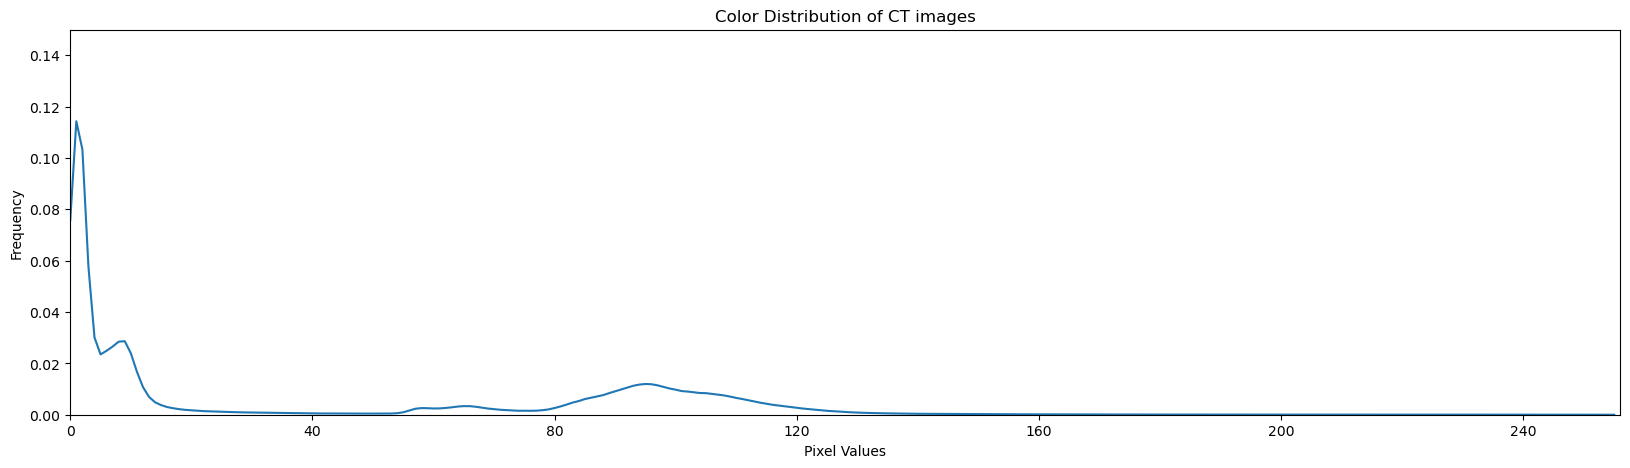

In [7]:
# Color distribution of quarter CT images
pixel_values_q, color_dist_q = l506_qd.color_histogram(plot=True)

### Morphological Analysis

We make sure that our synthetic images follows the same morphological pattern. We then analysis which object is better to use during dead leaves generation and also which size of the object is preferred.

#### Object to Use

Useful documentation for [morphological](https://scikit-image.org/docs/stable/auto_examples/applications/plot_morphology.html#sphx-glr-auto-examples-applications-plot-morphology-py) analysis, fourier transform, ...

To do so, compute some erosion and dilation images using different object (circle, square, line, ...) and compare them to the original image. The most similar transformed image will give us which object to use.

In [8]:
# TODO: make the morphological analysis
# These arguments are set to have the same "size" to compare them fairly
args = {'disk': {'radius': 2,
                 'dtype': np.uint8,
                 'strict_radius': True},
        'ellipse': {'width': 1,
                    'height': 2,
                    'dtype': np.uint8},
        'square': {'width': 5,
                   'dtype': np.uint8}}

# Set the morphologies you want to test then
morphologies = {'disk': disk(**args['disk']),
                'ellipse': ellipse(**args['ellipse']),
                'square': square(**args['square'])}

# Compute the analysis
results = l506_qd.morphological_analysis(morphologies)
display(results)

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/211 [00:00<?, ?it/s]

,ssim_opening_avg,ssim_closing_avg
disk,0.904550,0.948045
ellipse,0.888198,0.942460
square,0.843461,0.920798


We will use Structural Similarity Index (SSIM) to compare similarity between images.

#### Size of Object

To have this information, few ways are possible.

1) Directional Gradient Histogram
2) Fourier Transformation

##### 1) Directional Gradient Histogram

Here we basically compute the difference between each neighbour pixels (for each direction) and compute its histogram. Then we try to fit a Laplace distribution on it.

$e^{-\alpha|x|}$

This way, we find hthe $\alpha$ value that will give us information on the size of the object to use.

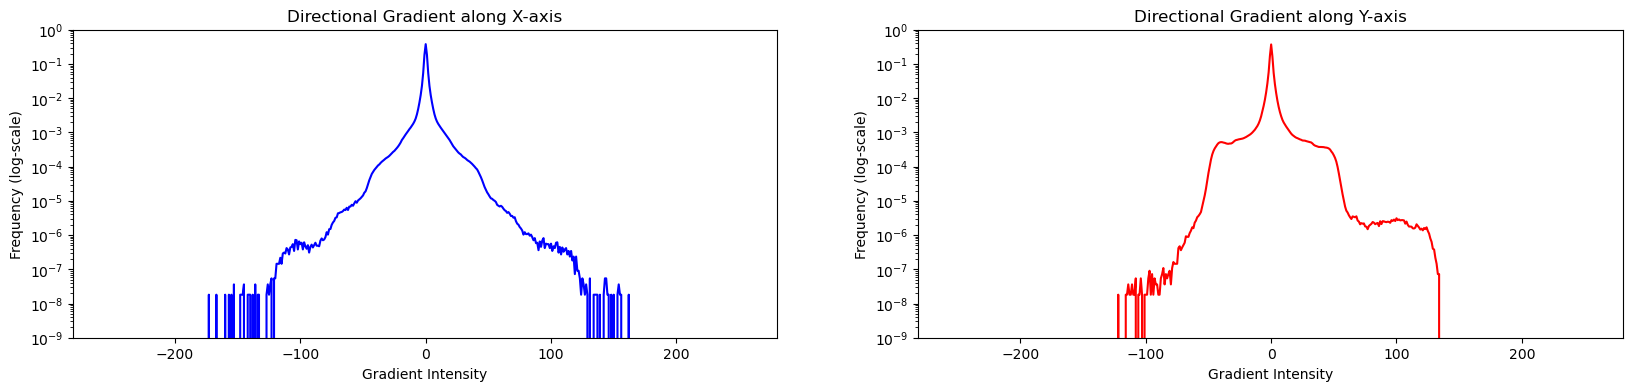

In [9]:
# let's select one image to create function that compute distribution of directional gradient histogram
grad_dist_x, grad_dist_y, grad_intensity = l506_fd.directional_gradient(plot=True)

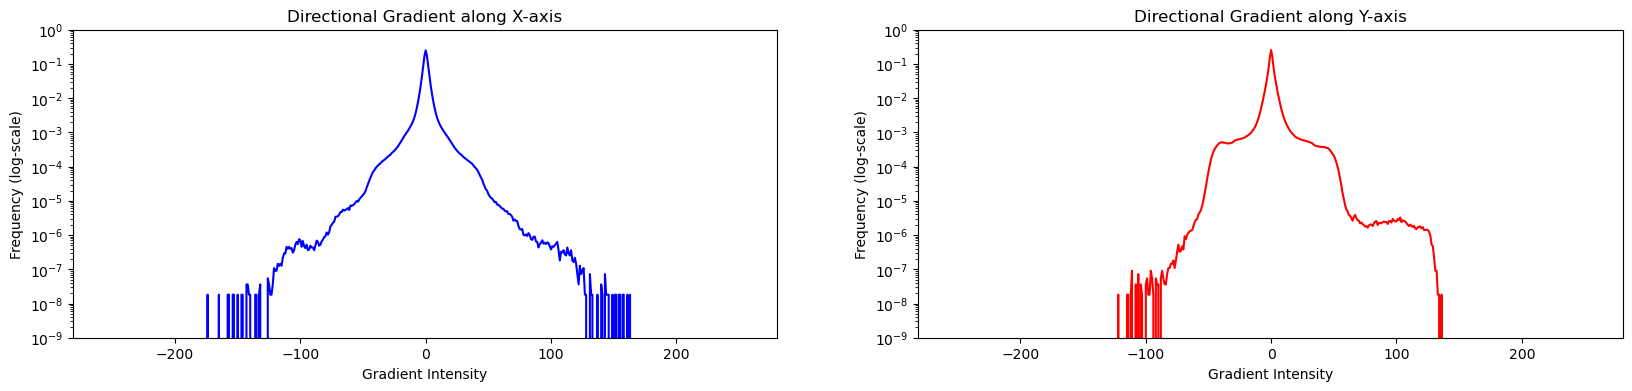

In [10]:
histo_x, histo_y, bins = l506_qd.directional_gradient(plot=True)

##### 2) Fourier Transformation

Compute the Fourier transform of images and look at the y and x-axis (middle to positive) of this 3D graph (2D for the image dimension and the third with the fourier value at this point). The slope of the log plot will be interesting. Don't know why at the moment.

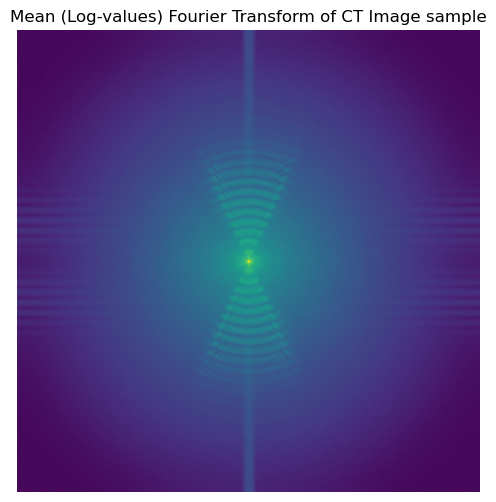

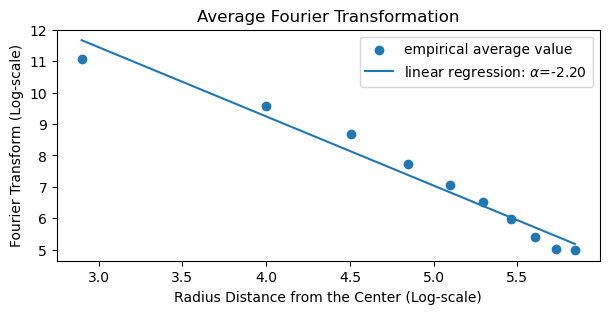

In [11]:
alpha = l506_qd.fourier_transform_analysis(plot=True)

## Synthetic Images Generation

Now, let's compute our synthetic images using our knowledge from the real CT images.

In [20]:
dl_args = {
    'alpha': 2.20,
    'r_min': 16, 
    'r_max': 500, 
    'color_distribution': color_dist_f, 
    'width': 500, 
    'height': 500, 
    'max_object': 10000
}

dead_leaves = dead_leaves_generator(10, dl_args)

  0%|          | 0/10 [00:00<?, ?it/s]

Radius min:  16
Radius max:  500
Alpha:  2.2
Number of images:  10
----------- idx: 0 -----------
Disk number:  4346
Width:  500
Height:  500
Radius mean:  49.0524620340543


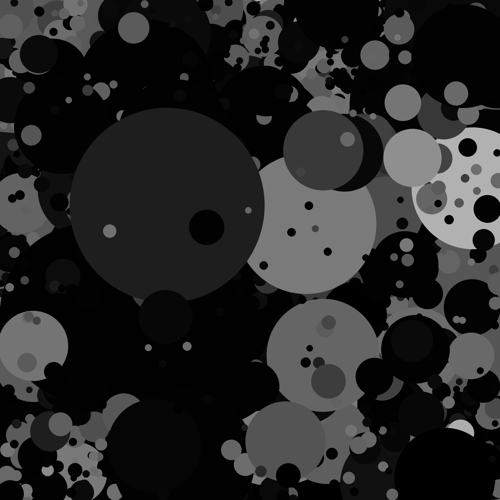

In [21]:
idx = 0

print("Radius min: ", dead_leaves.r_min)
print("Radius max: ", dead_leaves.r_max)
print("Alpha: ", dead_leaves.alpha)
print("Number of images: ", dead_leaves.len)
print(f"----------- idx: {idx} -----------")
print("Disk number: ", dead_leaves.imgs[idx].disk_number)
print("Width: ", dead_leaves.imgs[idx].width)
print("Height: ", dead_leaves.imgs[idx].height)
print("Radius mean: ", dead_leaves.imgs[idx].r_mean)
dead_leaves.imgs[idx].pil

Radius min:  16
Radius max:  500
Alpha:  2.2
Number of images:  10
----------- idx: 5 -----------
Disk number:  3913
Width:  500
Height:  500
Radius mean:  48.87860976233069


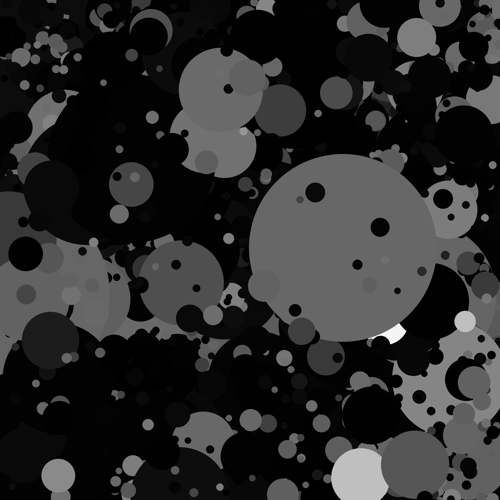

In [22]:
idx = 5

print("Radius min: ", dead_leaves.r_min)
print("Radius max: ", dead_leaves.r_max)
print("Alpha: ", dead_leaves.alpha)
print("Number of images: ", dead_leaves.len)
print(f"----------- idx: {idx} -----------")
print("Disk number: ", dead_leaves.imgs[idx].disk_number)
print("Width: ", dead_leaves.imgs[idx].width)
print("Height: ", dead_leaves.imgs[idx].height)
print("Radius mean: ", dead_leaves.imgs[idx].r_mean)
dead_leaves.imgs[idx].pil

Radius min:  16
Radius max:  500
Alpha:  2.2
Number of images:  10
----------- idx: 9 -----------
Disk number:  3358
Width:  500
Height:  500
Radius mean:  48.78648004764741


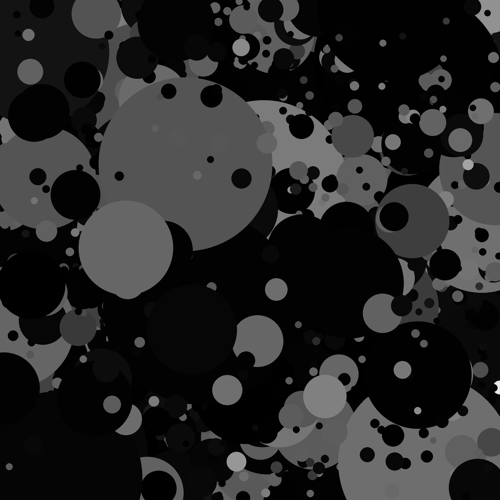

In [23]:
idx = 9

print("Radius min: ", dead_leaves.r_min)
print("Radius max: ", dead_leaves.r_max)
print("Alpha: ", dead_leaves.alpha)
print("Number of images: ", dead_leaves.len)
print(f"----------- idx: {idx} -----------")
print("Disk number: ", dead_leaves.imgs[idx].disk_number)
print("Width: ", dead_leaves.imgs[idx].width)
print("Height: ", dead_leaves.imgs[idx].height)
print("Radius mean: ", dead_leaves.imgs[idx].r_mean)
dead_leaves.imgs[idx].pil

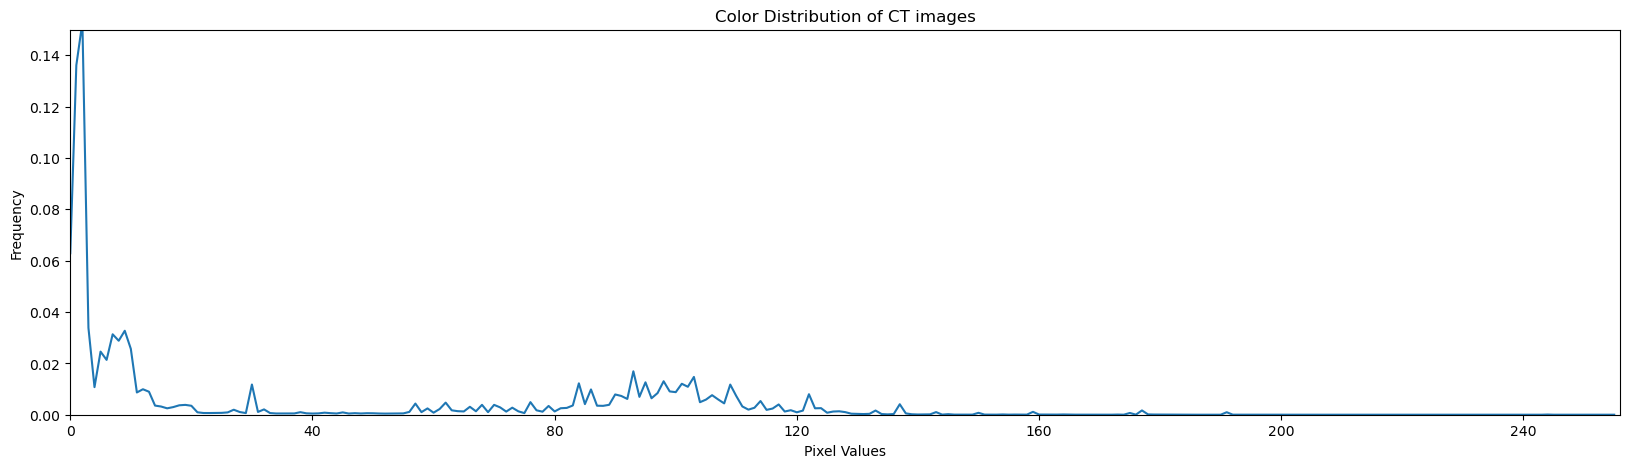

In [24]:
dl_color_hist = dead_leaves.color_histogram(plot=True)

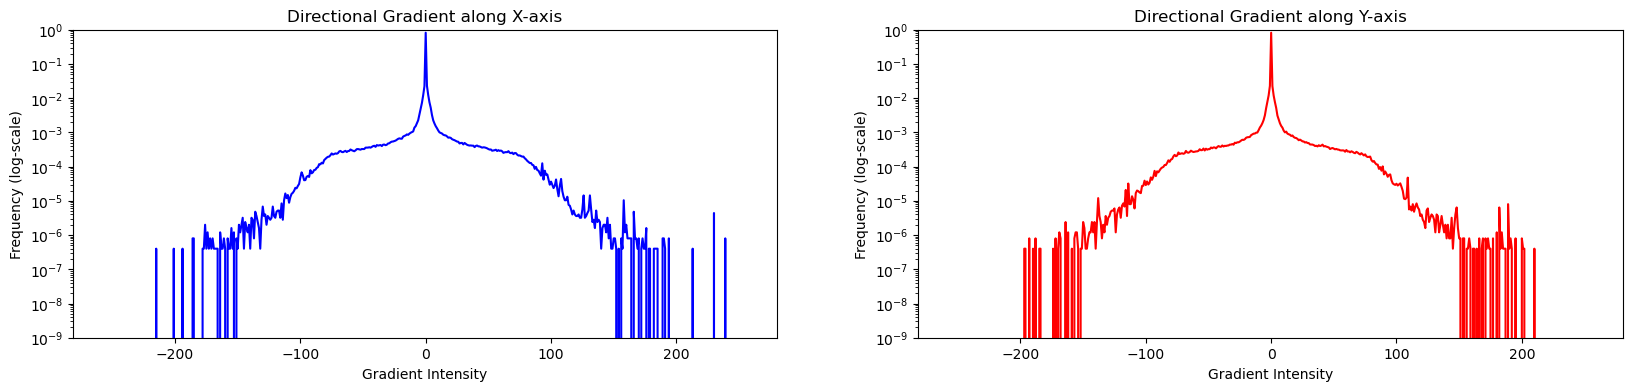

In [25]:
dl_grad_dist_x, dl_grad_dist_y, dl_grad_intensity = dead_leaves.directional_gradient(plot=True)

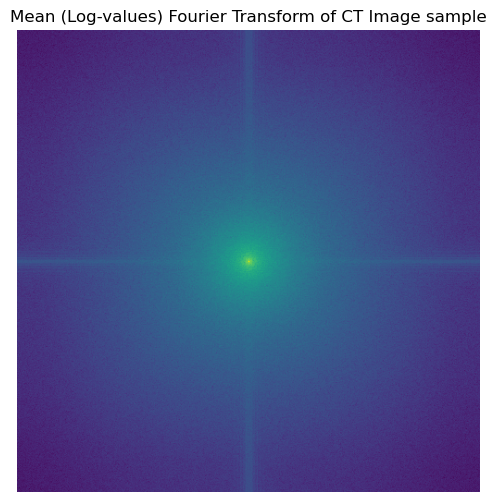

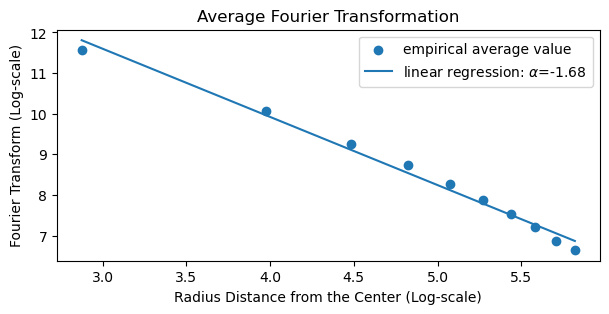

In [26]:
dl_alpha = dead_leaves.fourier_transform_analysis(plot=True)

## Noise Statistical Analysis

Use the full and quarter dose projection, respectively FD and QD, to empirically compute the noise distribution. This way, we will be able to add some noise on our synthetic images to be able to train our model later on.

In [19]:
#TODO: Compute the noise distribution observed on our sample of CT real images